# Integration of Rate Equations in Plasticity

#### Import packages

In [1]:
import numpy as np
from scipy.interpolate import PPoly
import matplotlib.pyplot as plt

#### Material properties

In [2]:
E = 210000      # Youngs modulus in MPa
Rp = 235        # yield stress in MPa

### Strain history

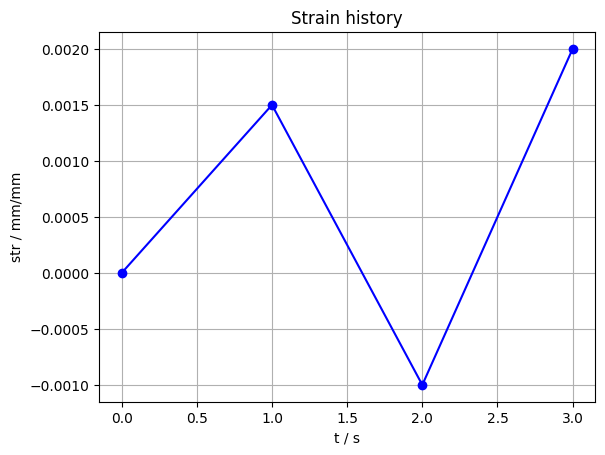

In [3]:
timeD = np.array([0, 1, 2, 3])                      # discrete time in s
strD  = 1E-3*np.array([0.0, 1.5, -1.0, 2.0])         # discrete strain in m/m

# plot
plt.plot(timeD, strD, '-bo')
plt.xlabel('t / s')
plt.ylabel('str / mm/mm')
plt.grid('on')
plt.title('Strain history')
#plt.xlim((0, np.max(timeD)))
#plt.ylim((np.min(strD), np.max(strD)))
plt.show()

#### Determine strain rate

In [4]:
# Calculate slopes (m) for each segment
slopes = np.diff(strD) / np.diff(timeD)  # (y2 - y1) / (x2 - x1)

# Arrange coefficients for PPoly
coefficients = np.vstack((slopes, strD[:-1]))  # Each segment: [m, b]

# Create a piecewise polynomial object
str = PPoly(coefficients, timeD)

# Compute the first derivative of the piecewise polynomial
dstrT = str.derivative()

# Evaluate the piecewise polynomial at a range of points
t_int = np.linspace(timeD[0], timeD[-1], timeD[-1]*500)

### Integration

In [5]:
# Number of steps in time integration
numStep = len(t_int)

# Time step for integration
dt = t_int[1] - t_int[0]

# allocate vectors
sig  = np.zeros((numStep, 1))   # stress
str  = np.zeros((numStep, 1))   # total strain
strP = np.zeros((numStep, 1))   # plastic strain

# *** INTEGRATON OF LOADING HISTORY ***
for i in range(1, numStep):

    # strain rate
    dstr = dstrT(t_int[i])

    # elastic trial stress
    sigTr = sig[i-1] + E*dstr*dt

    # *** ELASTIC STEP ***
    if np.abs(sigTr) < Rp: # evaluate yield function

        dstrE = dstr    # elastic strain rate
        dstrP = 0       # plastic strain rate

    # *** PLASTIC STEP ***
    else:

        dstrE = 0       # elastic strain rate
        dstrP = dstr    # plastic strain rate

    # integration (explicit euler)
    str[i]  = str[i-1]  + dstr*dt
    sig[i]  = sig[i-1]  + E*dstrE*dt
    strP[i] = strP[i-1] + dstrP*dt

### Plot results

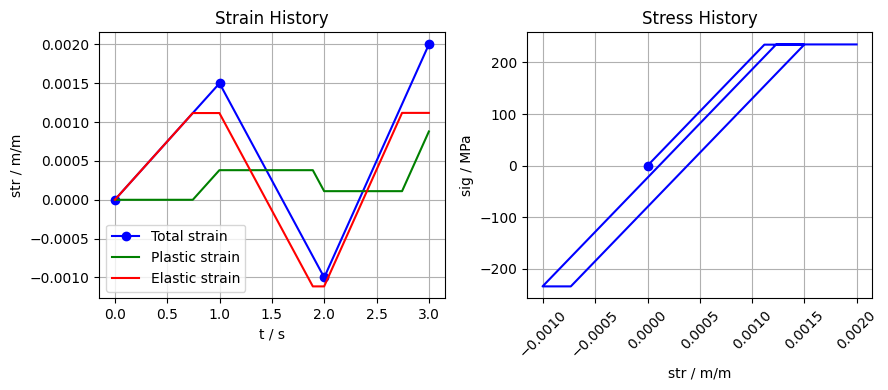

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot strain history
ax1.plot(timeD, strD, '-bo', label='Total strain')
ax1.plot(t_int, strP, 'g', label='Plastic strain')
ax1.plot(t_int, str - strP, 'r', label='Elastic strain')
ax1.grid('on')
ax1.set_xlabel('t / s')
ax1.set_ylabel('str / m/m')
ax1.set_title('Strain History')
ax1.legend()

# Plot stress history
ax2.plot(str, sig, 'b')
ax2.plot(0, 0, 'bo')
ax2.grid('on')
ax2.set_xlabel('str / m/m')
ax2.set_ylabel('sig / MPa')
ax2.set_title('Stress History')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()